
# FNOを用いた2次元Darcy-Flowの学習

#### 必要なパッケージのインポート

In [88]:
import torch
import matplotlib.pyplot as plt
import sys
import datetime
import os
from io import StringIO

from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

#### コード内で使用するパラメータまとめ

##### データの読み込み関係

In [89]:
device = 'cpu'
N_train = 100
batch_size = 32
test_resolutions = [16, 32]
N_tests = [100, 50]
test_batch_sizes = [32, 32]

##### FNOモデル関係

In [90]:
N_modes = (16, 16)
in_channels = 1
out_channels = 1
hidden_channels = 32
projection_channel_ratio = 2

##### optimizer関係

In [91]:
lerning_rate = 8e-3
weight_decay = 1e-4
T_max = 30

##### トレーナー関係

In [92]:
N_epochs = 20
wandb_log = False
eval_interval = 1
use_distributed = False
verbose = True
regularizer = False

##### ファイル出力関係

In [93]:
dt_now = datetime.datetime.now()
output_dir = "../results/FNO/" + dt_now.strftime("%Y-%m-%d_%H:%M:%S") + "/"

os.makedirs(output_dir, exist_ok=True)

# 標準出力をキャプチャする関数
def capture_output(func, *args, **kwargs):
    # 元の標準出力を保存
    original_stdout = sys.stdout
    sys.stdout = StringIO()  # 標準出力をStringIOに切り替え

    try:
        func(*args, **kwargs)  # 渡された関数を実行
        output = sys.stdout.getvalue()  # キャプチャされた出力を取得
    finally:
        sys.stdout = original_stdout  # 標準出力を元に戻す

    return output

#### 使用するデータの読み込み（今回はsmall Darcy-flow datasetを使用）

In [94]:
train_loader, test_loaders, data_processor = load_darcy_flow_small(
        n_train=N_train, batch_size=batch_size, 
        test_resolutions=test_resolutions, n_tests=N_tests,
        test_batch_sizes=test_batch_sizes,
)
data_processor = data_processor.to(device)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


/home/shimi3435/workspace/python/neuralop_test_semi/neuraloperator/neuralop/data/datasets/pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(


#### FNOモデルの作成

In [95]:
model = FNO(n_modes=N_modes,
             in_channels=in_channels, 
             out_channels=out_channels,
             hidden_channels=hidden_channels, 
             projection_channel_ratio=projection_channel_ratio)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


#### optimizerの作成



In [96]:
optimizer = AdamW(model.parameters(), lr=lerning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

#### 使用するロスの設定

In [97]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

#### モデル、optimizer、scheduler、ロスのログ出力

In [98]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 

#### トレーナーの作成


In [99]:
trainer = Trainer(model=model, n_epochs=N_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=wandb_log,
                  eval_interval=eval_interval,
                  use_distributed=use_distributed,
                  verbose=verbose)

#### 学習


In [100]:
stdout = capture_output(lambda : trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=regularizer, 
              training_loss=train_loss,
              eval_losses=eval_losses))

print(stdout)

Training on 100 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=0.44, avg_loss=0.9912, train_err=24.7810
Eval: 16_h1=0.8966, 16_l2=0.5834, 32_h1=0.9398, 32_l2=0.5781
[1] time=0.35, avg_loss=0.9287, train_err=23.2169
Eval: 16_h1=0.8827, 16_l2=0.5759, 32_h1=0.8973, 32_l2=0.5711
[2] time=0.32, avg_loss=0.8679, train_err=21.6974
Eval: 16_h1=0.6946, 16_l2=0.7361, 32_h1=0.7851, 32_l2=0.7554
[3] time=0.32, avg_loss=0.6205, train_err=15.5119
Eval: 16_h1=0.5822, 16_l2=0.6928, 32_h1=0.6832, 32_l2=0.6903
[4] time=0.38, avg_loss=0.5494, train_err=13.7339
Eval: 16_h1=0.4837, 16_l2=0.4670, 32_h1=0.6321, 32_l2=0.4694
[5] time=0.33, avg_loss=0.4778, train_err=11.9460
Eval: 16_h1=0.5057, 16_l2=0.3516, 32_h1=0.6192, 32_l2=0.3514
[6] time=0.33, avg_loss=0.4698, train_err=11.7452
Eval: 16_h1=0.4414, 16_l2=0.3176, 32_h1=0.6246, 32_l2=0.3209
[7] time=0.32, avg_loss=0.4176, train_err=10.4395
Eval: 16_h1=0.4193, 16_l2=0.2838, 32_h1

#### プログラムの実行結果のファイル出力

In [101]:
with open(output_dir + 'stdout.txt', 'w') as f:
    f.write(stdout)

with open(output_dir + 'models.txt', 'w') as f:
    f.write(f'\nOur model has {n_params} parameters.\n')
    f.write('\n\n### MODEL ###\n')
    f.write(str(model))
    f.write('\n\n### OPTIMIZER ###\n')
    f.write(str(optimizer))
    f.write('\n\n### SCHEDULER ###\n')
    f.write(str(scheduler))
    f.write('\n\n### LOSSES ###')
    f.write(f'\n\n * Train: {train_loss}')
    f.write(f'\n\n * Test: {eval_losses}')
    
with open(output_dir + 'params.txt', 'w') as f:
    f.write(f'N_train: {N_train}\n')
    f.write(f'batch_size: {batch_size}\n')
    f.write(f'test_resolutions: {test_resolutions}\n')
    f.write(f'N_tests: {N_tests}\n')
    f.write(f'test_batch_sizes: {test_batch_sizes}\n')
    f.write(f'N_modes: {N_modes}\n')
    f.write(f'in_channels: {in_channels}\n')
    f.write(f'out_channels: {out_channels}\n')
    f.write(f'hidden_channels: {hidden_channels}\n')
    f.write(f'projection_channel_ratio: {projection_channel_ratio}\n')
    f.write(f'lerning_rate: {lerning_rate}\n')
    f.write(f'weight_decay: {weight_decay}\n')
    f.write(f'T_max: {T_max}\n')
    f.write(f'N_epochs: {N_epochs}\n')
    f.write(f'wandb_log: {wandb_log}\n')
    f.write(f'eval_interval: {eval_interval}\n')
    f.write(f'use_distributed: {use_distributed}\n')
    f.write(f'verbose: {verbose}\n')
    f.write(f'regularizer: {regularizer}\n')

Visualizing predictions
------------------------
Let's take a look at what our model's predicted outputs look like. 
Again note that in this example, we train on a very small resolution for
a very small number of epochs.
In practice, we would train at a larger resolution, on many more samples.



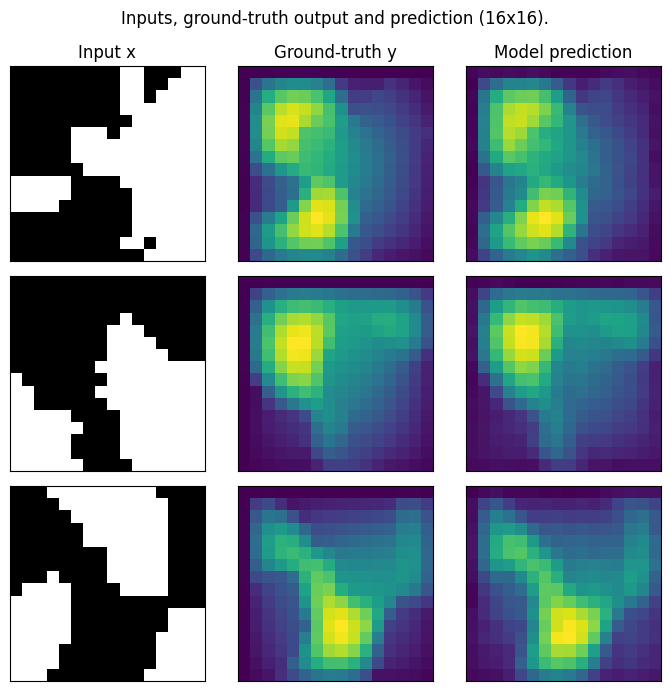

In [102]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
plt.show()

Zero-shot super-evaluation
---------------------------
In addition to training and making predictions on the same input size, 
the FNO's invariance to the discretization of input data means we 
can natively make predictions on higher-resolution inputs and get higher-resolution outputs.



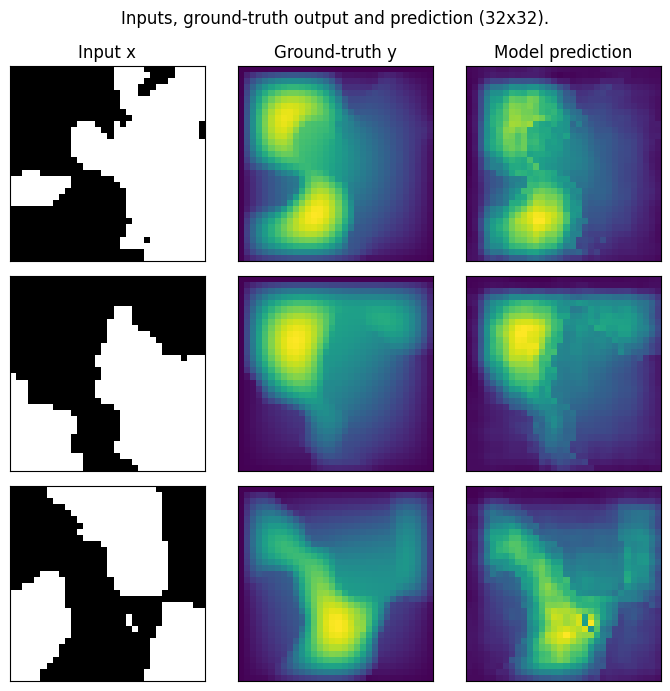

In [103]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
plt.show()

We only trained the model on data at a resolution of 16x16, and with no modifications 
or special prompting, we were able to perform inference on higher-resolution input data 
and get higher-resolution predictions! In practice, we often want to evaluate neural operators
at multiple resolutions to track a model's zero-shot super-evaluation performance throughout 
training. That's why many of our datasets, including the small Darcy-flow we showcased,
are parameterized with a list of `test_resolutions` to choose from. 

However, as you can see, these predictions are noisier than we would expect for a model evaluated 
at the same resolution at which it was trained. Leveraging the FNO's discretization-invariance, there
are other ways to scale the outputs of the FNO to train a true super-resolution capability. 
